# Contextual Bandits

## Notes
### Problem
- Context covariates are available at each iteration, rewards are also dependent on these covariates.
- Covariates `X`, a vector of rewards `r` of length `m`, i.e. the number or arms.
- Purpose is to build a policy that **maximizes rewards over time.**
- This is more important when new arms are introduced, arms might also expire over time.
- Very similar to multi-class or multi-label classification problems (reward being whether the right label was chosen or not), **but with the huge difference that the right label is not known for each observation**.
  - `Online Advertising`: We only know whether a user clicked an ad that he was presented with, but don't know which other ads he would have clicked.
  - `Clinical Trials`: We only know how a person responded to a treatment, but don't know how they would have responded to a different treatment.
- This notebook deals with the problem of building online algorithms that would work with little or no data for new or little-known arms or exploiting what's known to be good arms.

### Algorithms
 - Take a binary classifier algorithm as a base or `Oracle`.
 - `Upper Confidence Bounds`
 - `Thompson Sampling`
 - `Epsilon Greedy`
 - `Adaptive Greedy`
 - `Explore then Exploit`
 - `Active Explorer`
 - Heuristics are enhanced with an optional `beta prior` for arms for which not enough information to build a classifier is available.
  
## Experiments
- It is possible to turn any multi-label classification dataset into contextual bandits by **revealing only the class for one label per observation.** Doing this also has the advantage that we know also the rewards for all other arms when we want to evaluate a policy, but we can **choose not to reveal them to the agent** to simulate a real scenario.


## References
[Online Contextual Bandits](https://nbviewer.org/github/david-cortes/contextualbandits/blob/master/example/online_contextual_bandits.ipynb)

# Imports

In [1]:
import pandas as pd, numpy as np, re
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.datasets import load_svmlight_file

In [114]:
import sys

!{sys.executable} -m pip install matplotlib -q


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


# Read

In [22]:
def parse_data(filename):
    with open(filename, "rb") as f:
        infoline = f.readline()
        infoline = re.sub(r"^b'", "", str(infoline))
        n_features = int(re.sub(r"^\d+\s(\d+)\s\d+.*$", r"\1", infoline))
        features, labels = load_svmlight_file(f, n_features=n_features, multilabel=True)
    mlb = MultiLabelBinarizer()
    labels = mlb.fit_transform(labels)
    features = np.array(features.todense())
    features = np.ascontiguousarray(features)
    return features, labels


X, y = parse_data("data/bibtex_data.txt")
print(X.shape)
print(y.shape)
print(f"Records: {y.shape[0]}, Features: {X.shape[1]}, Classes: {y.shape[1]}")

(7395, 1836)
(7395, 159)
Records: 7395, Features: 1836, Classes: 159


# Explore

In [15]:
# sparse labels, max label only available for 1000/7400 of records, i.e. max 20%
pd.melt(pd.DataFrame(y)).groupby("variable").sum().sort_values(by="value")

,value
variable,
31,51
136,51
28,51
40,52
46,52
...,...
52,294
75,307
131,443


In [20]:
# large number of contextual features, 1800, some dense, 80%+, some very sparse
pd.melt(pd.DataFrame(X)).groupby("variable").sum().sort_values(by="value")

,value
variable,
597,22.0
780,23.0
1270,23.0
1052,24.0
228,25.0
...,...
44,6207.0
129,6507.0
1667,6720.0


# Models

In [24]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import (
    BootstrappedUCB,
    BootstrappedTS,
    SeparateClassifiers,
    EpsilonGreedy,
    AdaptiveGreedy,
    ExploreFirst,
    ActiveExplorer,
    SoftmaxExplorer,
)
from copy import deepcopy

## Base Classifier Algorithm

In [31]:
base_algorithm = LogisticRegression(solver="lbfgs", warm_start=True)

## Priors

In [101]:
n_choices = n_classes = n_arms = y.shape[1]

beta_prior = (
    (3.0 / n_choices, 4),
    2,
)  # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = (
    (5.0 / n_choices, 4),
    2,
)  # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2.0 / np.log2(n_choices), 4), 2)

print(beta_prior, beta_prior_ucb, beta_prior_ts)

((0.018867924528301886, 4), 2) ((0.031446540880503145, 4), 2) ((0.2734899508482878, 4), 2)


## Active Learning Algorithms

In [102]:
## The base algorithm is embedded in different metaheuristics
m_bs_ucb = BootstrappedUCB(
    deepcopy(base_algorithm),
    nchoices=n_choices,
    beta_prior=beta_prior_ucb,
    percentile=80,
)
m_bs_ts = BootstrappedTS(
    deepcopy(base_algorithm), nchoices=n_choices, beta_prior=beta_prior_ts
)
m_eps_greedy = EpsilonGreedy(
    deepcopy(base_algorithm), nchoices=n_choices, beta_prior=beta_prior
)
m_ada_greedy = AdaptiveGreedy(
    deepcopy(base_algorithm),
    nchoices=n_choices,
    decay_type="threshold",
    beta_prior=beta_prior,
)
models = [m_bs_ucb, m_bs_ts, m_eps_greedy, m_ada_greedy]

In [103]:
rewards = [list() for i in range(len(models))]

# batch size - algorithms will be refit after N rounds
batch_size = 32
first_batch = X[:batch_size, :]

# initial seed - all policies start with the same small random selection of actions/rewards
np.random.seed(42)
action_chosen = np.random.randint(n_choices, size=batch_size)
rewards_received = y[np.arange(batch_size), action_chosen]

actions = [action_chosen.copy() for i in range(len(models))]
print(len(action_chosen), len(rewards_received), len(rewards), len(actions))

32 32 4 4


In [104]:
# fitting models for the first time
for model in models:
    model.fit(X=first_batch, a=action_chosen, r=rewards_received)

In [105]:
# rounds are simulated from the full dataset
def simulate_rounds(
    model, rewards, actions_hist, X_global, y_global, batch_st, batch_end
):
    np.random.seed(batch_st)

    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype("uint8")

    # keeping track of the sum of rewards received
    rewards.append(y_global[np.arange(batch_st, batch_end), actions_this_batch].sum())

    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)

    # now refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    model.fit(
        X_global[:batch_end, :],
        new_actions_hist,
        y_global[np.arange(batch_end), new_actions_hist],
    )

    return new_actions_hist


# now running all the simulation
for i in tqdm(range(int(np.floor(X.shape[0] / batch_size)))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X.shape[0]])

    for model in range(len(models)):
        actions[model] = simulate_rounds(
            models[model], rewards[model], actions[model], X, y, batch_st, batch_end
        )

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 231/231 [1:14:56<00:00, 19.46s/it]


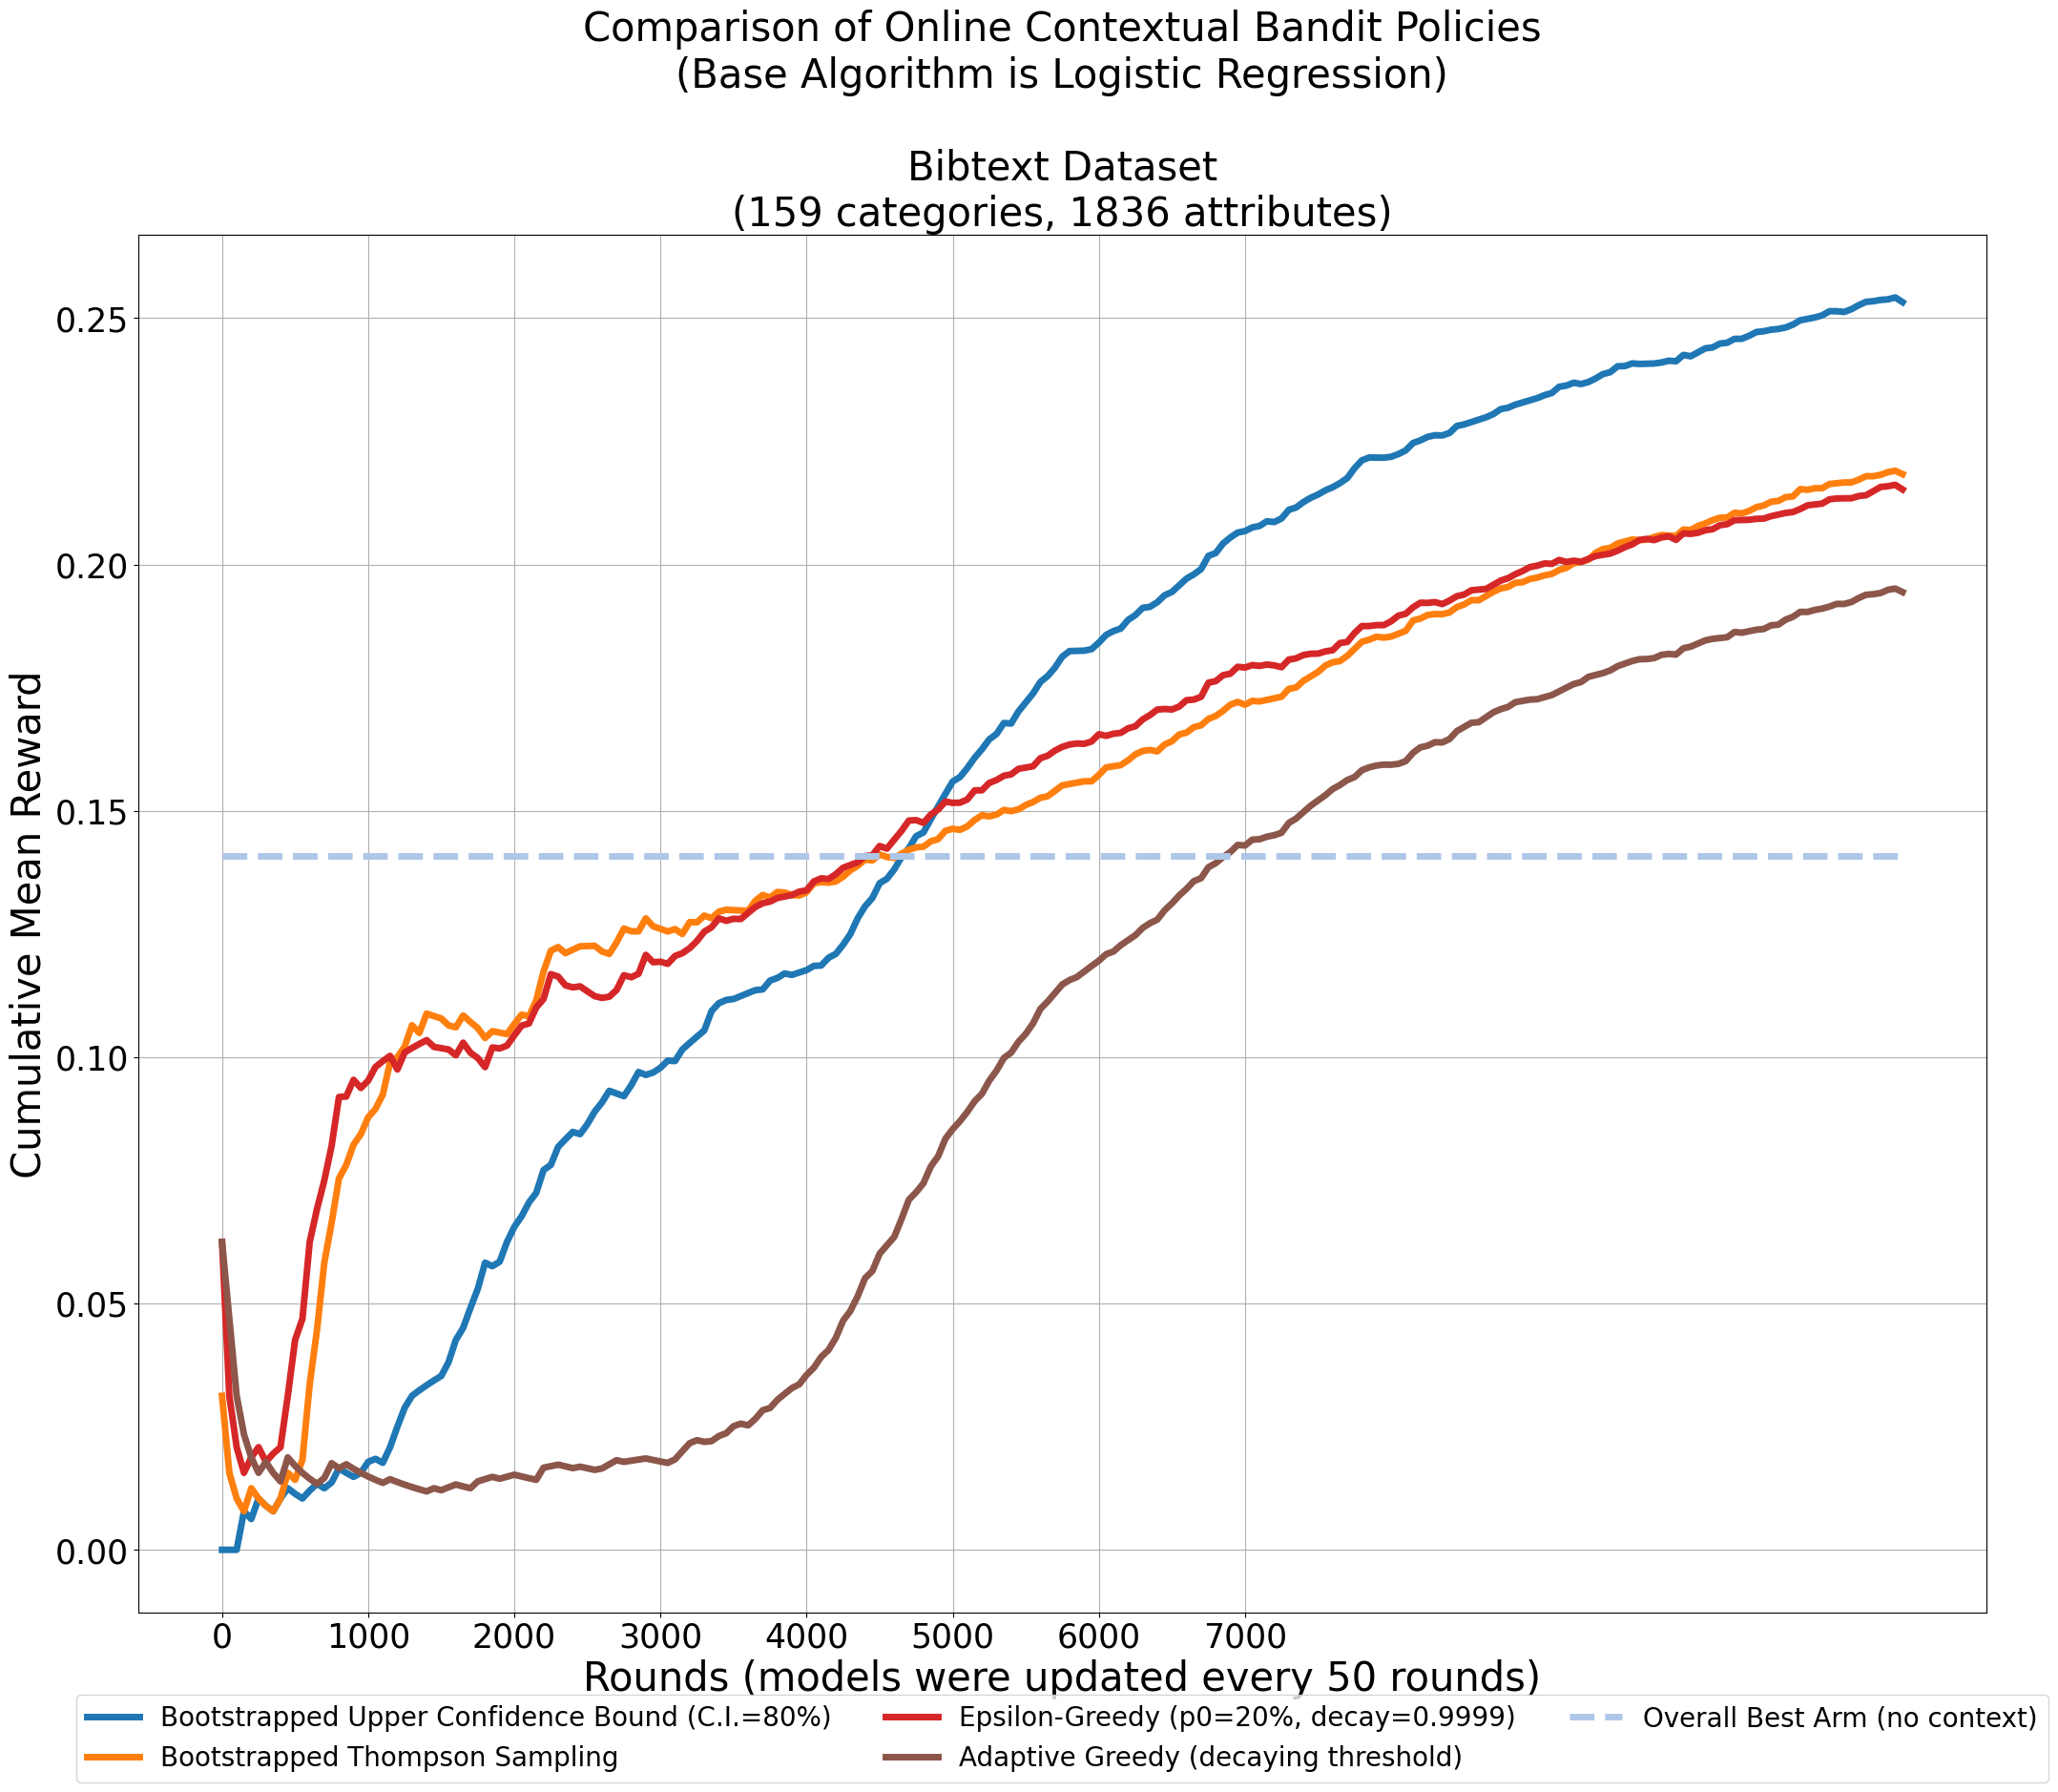

In [117]:
import matplotlib.pyplot as plt
from pylab import rcParams

%matplotlib inline


def get_mean_reward(reward_lst, batch_size=batch_size):
    mean_rew = list()
    for r in range(len(reward_lst)):
        mean_rew.append(sum(reward_lst[: r + 1]) * 1.0 / ((r + 1) * batch_size))
    return mean_rew


rcParams["figure.figsize"] = 25, 15
lwd = 5
cmap = plt.get_cmap("tab20")
colors = plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(
    get_mean_reward(rewards[0]),
    label="Bootstrapped Upper Confidence Bound (C.I.=80%)",
    linewidth=lwd,
    color=colors[0],
)
plt.plot(
    get_mean_reward(rewards[1]),
    label="Bootstrapped Thompson Sampling",
    linewidth=lwd,
    color=colors[2],
)
plt.plot(
    get_mean_reward(rewards[2]),
    label="Epsilon-Greedy (p0=20%, decay=0.9999)",
    linewidth=lwd,
    color=colors[6],
)
plt.plot(
    get_mean_reward(rewards[3]),
    label="Adaptive Greedy (decaying threshold)",
    linewidth=lwd,
    color=colors[10],
)
plt.plot(
    np.repeat(y.mean(axis=0).max(), len(rewards[0])),
    label="Overall Best Arm (no context)",
    linewidth=lwd,
    color=colors[1],
    ls="dashed",
)


# import warnings
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1, box.width, box.height * 1.25])
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.05),
    fancybox=True,
    ncol=3,
    prop={"size": 20},
)


plt.tick_params(axis="both", which="major", labelsize=25)
plt.xticks([i * 20 for i in range(8)], [i * 1000 for i in range(8)])


plt.xlabel("Rounds (models were updated every 50 rounds)", size=30)
plt.ylabel("Cumulative Mean Reward", size=30)
plt.title(
    "Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nBibtext Dataset\n(159 categories, 1836 attributes)",
    size=30,
)
plt.grid()
plt.show()